# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [12]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

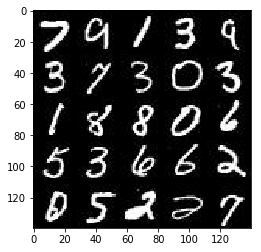

In [13]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

Done


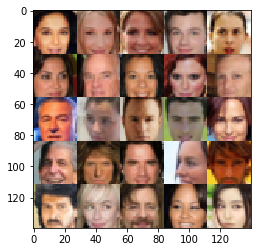

In [14]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

print('Done')

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
    

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [16]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, (None), name='leaning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)


Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [17]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64

        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128

        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [18]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
#         x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
#         x3 = tf.layers.batch_normalization(x3, training=is_train)
#         x3 = tf.maximum(alpha * x3, x3)
#         # 28x28x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [19]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    alpha = 0.2
    
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [20]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [21]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [57]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print('Starting GAN')
    image_width = data_shape[1]
    image_height = data_shape[2]
    out_channel_dim = data_shape[3]
    
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, out_channel_dim, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    print('GAN Setup')
    
    saver = tf.train.Saver()

    print_every = 20
    print_image = 100
    samples, losses = [], []
    steps = 0
    n_images = 9

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images = batch_images * 2 # Scale the images between -1 and 1

                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                # Print out metrics
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count), 
                          "Batch {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                # Print out progress from generator every so often
                if steps % print_image == 0:
                    show_generator_output(sess, n_images, input_z, out_channel_dim, data_image_mode)
                
        saver.save(sess, '/output/generator.ckpt')
    
                
print('done')                

                

done


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Starting GAN
GAN Setup
Epoch 1/1... Batch 20... Discriminator Loss: 3.7940... Generator Loss: 1.7527
Epoch 1/1... Batch 40... Discriminator Loss: 0.4733... Generator Loss: 2.5644
Epoch 1/1... Batch 60... Discriminator Loss: 0.9120... Generator Loss: 1.8993
Epoch 1/1... Batch 80... Discriminator Loss: 2.4799... Generator Loss: 3.4505
Epoch 1/1... Batch 100... Discriminator Loss: 0.8810... Generator Loss: 2.0931


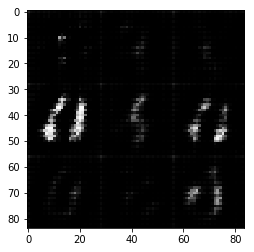

Epoch 1/1... Batch 120... Discriminator Loss: 1.5855... Generator Loss: 0.3736
Epoch 1/1... Batch 140... Discriminator Loss: 2.2235... Generator Loss: 0.1883
Epoch 1/1... Batch 160... Discriminator Loss: 1.0495... Generator Loss: 0.8112
Epoch 1/1... Batch 180... Discriminator Loss: 1.1521... Generator Loss: 1.7321
Epoch 1/1... Batch 200... Discriminator Loss: 2.7288... Generator Loss: 3.1603


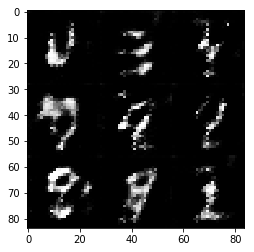

Epoch 1/1... Batch 220... Discriminator Loss: 1.0072... Generator Loss: 1.4278
Epoch 1/1... Batch 240... Discriminator Loss: 1.2486... Generator Loss: 0.6234
Epoch 1/1... Batch 260... Discriminator Loss: 1.3029... Generator Loss: 1.1721
Epoch 1/1... Batch 280... Discriminator Loss: 1.2394... Generator Loss: 0.6370
Epoch 1/1... Batch 300... Discriminator Loss: 1.4607... Generator Loss: 1.5051


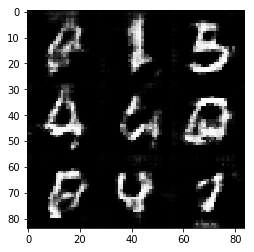

Epoch 1/1... Batch 320... Discriminator Loss: 1.2997... Generator Loss: 0.4976
Epoch 1/1... Batch 340... Discriminator Loss: 1.1091... Generator Loss: 0.8681
Epoch 1/1... Batch 360... Discriminator Loss: 1.3283... Generator Loss: 0.5897
Epoch 1/1... Batch 380... Discriminator Loss: 1.1454... Generator Loss: 0.6748
Epoch 1/1... Batch 400... Discriminator Loss: 1.0921... Generator Loss: 0.8471


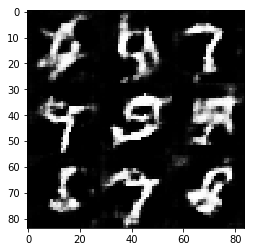

Epoch 1/1... Batch 420... Discriminator Loss: 0.9792... Generator Loss: 0.9719
Epoch 1/1... Batch 440... Discriminator Loss: 1.0907... Generator Loss: 1.4320
Epoch 1/1... Batch 460... Discriminator Loss: 1.1561... Generator Loss: 1.2562
Epoch 1/1... Batch 480... Discriminator Loss: 1.1708... Generator Loss: 0.7464
Epoch 1/1... Batch 500... Discriminator Loss: 1.4479... Generator Loss: 2.5676


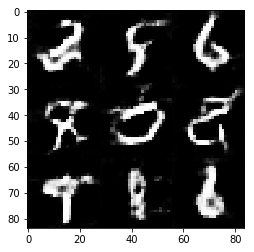

Epoch 1/1... Batch 520... Discriminator Loss: 1.2129... Generator Loss: 0.5529
Epoch 1/1... Batch 540... Discriminator Loss: 0.9959... Generator Loss: 0.9905
Epoch 1/1... Batch 560... Discriminator Loss: 1.1110... Generator Loss: 0.6964
Epoch 1/1... Batch 580... Discriminator Loss: 1.1658... Generator Loss: 0.5927
Epoch 1/1... Batch 600... Discriminator Loss: 1.1315... Generator Loss: 0.6649


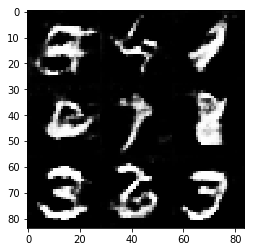

Epoch 1/1... Batch 620... Discriminator Loss: 1.2513... Generator Loss: 2.4869
Epoch 1/1... Batch 640... Discriminator Loss: 1.0017... Generator Loss: 1.0981
Epoch 1/1... Batch 660... Discriminator Loss: 1.0360... Generator Loss: 0.9240
Epoch 1/1... Batch 680... Discriminator Loss: 2.3620... Generator Loss: 0.1734
Epoch 1/1... Batch 700... Discriminator Loss: 1.1583... Generator Loss: 1.2684


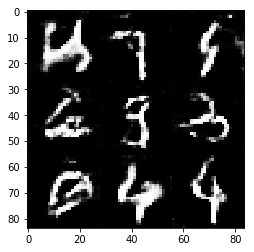

Epoch 1/1... Batch 720... Discriminator Loss: 1.0668... Generator Loss: 1.0856
Epoch 1/1... Batch 740... Discriminator Loss: 1.1020... Generator Loss: 0.6762
Epoch 1/1... Batch 760... Discriminator Loss: 0.8660... Generator Loss: 1.4022
Epoch 1/1... Batch 780... Discriminator Loss: 1.1917... Generator Loss: 0.6112
Epoch 1/1... Batch 800... Discriminator Loss: 1.0210... Generator Loss: 0.8236


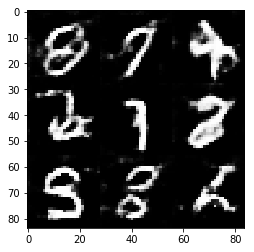

Epoch 1/1... Batch 820... Discriminator Loss: 0.9126... Generator Loss: 1.0558
Epoch 1/1... Batch 840... Discriminator Loss: 1.4481... Generator Loss: 2.3987
Epoch 1/1... Batch 860... Discriminator Loss: 1.0469... Generator Loss: 0.7030
Epoch 1/1... Batch 880... Discriminator Loss: 1.0018... Generator Loss: 1.0769
Epoch 1/1... Batch 900... Discriminator Loss: 1.1397... Generator Loss: 0.6030


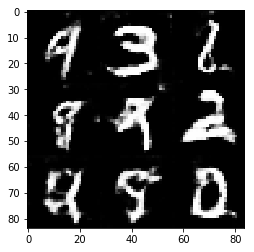

Epoch 1/1... Batch 920... Discriminator Loss: 1.1027... Generator Loss: 0.6163


ValueError: Parent directory of ./checkpoints/generator.ckpt doesn't exist, can't save.

In [52]:
batch_size = 128
z_dim = 100
learning_rate = 0.002 # 0.0002 slow # 0.02 over shooting
beta1 = 0.5 # From DCGAN exercises

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)
    
print('Done')

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Starting GAN
GAN Setup
Epoch 1/1... Batch 20... Discriminator Loss: 5.4261... Generator Loss: 19.6178
Epoch 1/1... Batch 40... Discriminator Loss: 0.4221... Generator Loss: 2.1887
Epoch 1/1... Batch 60... Discriminator Loss: 0.7434... Generator Loss: 0.8495
Epoch 1/1... Batch 80... Discriminator Loss: 0.6582... Generator Loss: 1.2968
Epoch 1/1... Batch 100... Discriminator Loss: 5.8912... Generator Loss: 10.8409


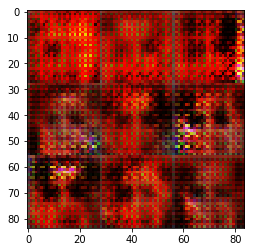

Epoch 1/1... Batch 120... Discriminator Loss: 0.4770... Generator Loss: 1.6981
Epoch 1/1... Batch 140... Discriminator Loss: 3.2203... Generator Loss: 0.1053
Epoch 1/1... Batch 160... Discriminator Loss: 2.7970... Generator Loss: 4.4736
Epoch 1/1... Batch 180... Discriminator Loss: 1.2619... Generator Loss: 0.4664
Epoch 1/1... Batch 200... Discriminator Loss: 0.7849... Generator Loss: 1.0369


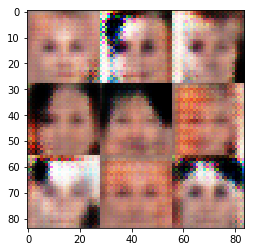

Epoch 1/1... Batch 220... Discriminator Loss: 1.4751... Generator Loss: 0.4127
Epoch 1/1... Batch 240... Discriminator Loss: 1.2735... Generator Loss: 0.4106
Epoch 1/1... Batch 260... Discriminator Loss: 2.1867... Generator Loss: 2.8964
Epoch 1/1... Batch 280... Discriminator Loss: 1.4426... Generator Loss: 0.7181
Epoch 1/1... Batch 300... Discriminator Loss: 1.2993... Generator Loss: 0.5922


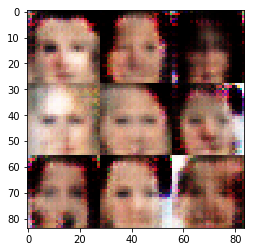

Epoch 1/1... Batch 320... Discriminator Loss: 1.2816... Generator Loss: 2.1986
Epoch 1/1... Batch 340... Discriminator Loss: 1.8348... Generator Loss: 1.3967
Epoch 1/1... Batch 360... Discriminator Loss: 3.2411... Generator Loss: 0.0596
Epoch 1/1... Batch 380... Discriminator Loss: 1.5783... Generator Loss: 2.8603
Epoch 1/1... Batch 400... Discriminator Loss: 1.4079... Generator Loss: 0.4214


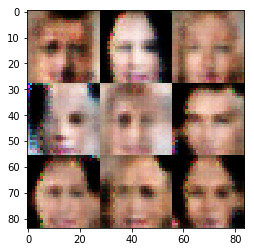

Epoch 1/1... Batch 420... Discriminator Loss: 1.0785... Generator Loss: 0.5821
Epoch 1/1... Batch 440... Discriminator Loss: 1.2728... Generator Loss: 0.7181
Epoch 1/1... Batch 460... Discriminator Loss: 2.3703... Generator Loss: 2.6611
Epoch 1/1... Batch 480... Discriminator Loss: 1.2822... Generator Loss: 0.6064
Epoch 1/1... Batch 500... Discriminator Loss: 1.1677... Generator Loss: 0.7421


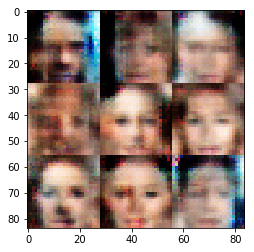

Epoch 1/1... Batch 520... Discriminator Loss: 1.2284... Generator Loss: 0.8409
Epoch 1/1... Batch 540... Discriminator Loss: 1.2695... Generator Loss: 0.8775
Epoch 1/1... Batch 560... Discriminator Loss: 1.0130... Generator Loss: 1.7617
Epoch 1/1... Batch 580... Discriminator Loss: 0.8384... Generator Loss: 1.4694
Epoch 1/1... Batch 600... Discriminator Loss: 1.4492... Generator Loss: 1.7635


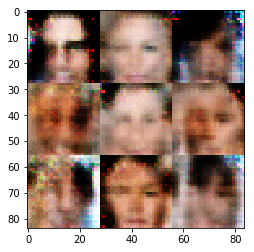

Epoch 1/1... Batch 620... Discriminator Loss: 1.1542... Generator Loss: 0.6878
Epoch 1/1... Batch 640... Discriminator Loss: 0.9313... Generator Loss: 0.6929
Epoch 1/1... Batch 660... Discriminator Loss: 0.1705... Generator Loss: 2.8311
Epoch 1/1... Batch 680... Discriminator Loss: 0.5398... Generator Loss: 1.2519
Epoch 1/1... Batch 700... Discriminator Loss: 0.1896... Generator Loss: 4.0239


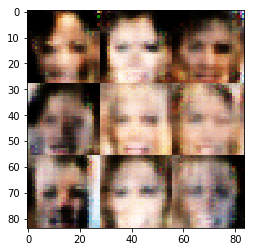

Epoch 1/1... Batch 720... Discriminator Loss: 2.1777... Generator Loss: 3.0479
Epoch 1/1... Batch 740... Discriminator Loss: 0.7717... Generator Loss: 1.5989
Epoch 1/1... Batch 760... Discriminator Loss: 1.1471... Generator Loss: 0.6063
Epoch 1/1... Batch 780... Discriminator Loss: 1.1324... Generator Loss: 0.7431
Epoch 1/1... Batch 800... Discriminator Loss: 2.0073... Generator Loss: 0.1870


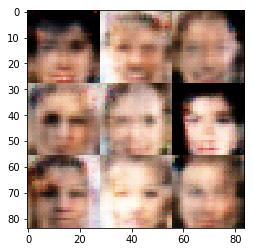

Epoch 1/1... Batch 820... Discriminator Loss: 1.1689... Generator Loss: 1.3143
Epoch 1/1... Batch 840... Discriminator Loss: 1.1226... Generator Loss: 0.5979
Epoch 1/1... Batch 860... Discriminator Loss: 1.1411... Generator Loss: 0.7333
Epoch 1/1... Batch 880... Discriminator Loss: 0.9355... Generator Loss: 0.6593
Epoch 1/1... Batch 900... Discriminator Loss: 1.2232... Generator Loss: 0.6631


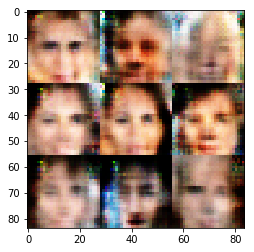

Epoch 1/1... Batch 920... Discriminator Loss: 1.3463... Generator Loss: 0.4904
Epoch 1/1... Batch 940... Discriminator Loss: 1.2537... Generator Loss: 0.6165
Epoch 1/1... Batch 960... Discriminator Loss: 1.2186... Generator Loss: 0.8044
Epoch 1/1... Batch 980... Discriminator Loss: 1.3402... Generator Loss: 0.9735
Epoch 1/1... Batch 1000... Discriminator Loss: 1.2673... Generator Loss: 0.8178


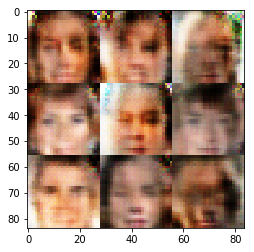

KeyboardInterrupt: 

In [58]:
batch_size = 128
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.